# Demo of SCOD with a simple 2D dataset

In [45]:
%load_ext autoreload
%autoreload 2

import scod
import torch
import numpy as np
from tqdm import trange

import seaborn as sns
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, define the dataset

In [2]:
class TwoDDataset(torch.utils.data.Dataset):
    def __init__(self, N=100, fn=np.sin, split='train') -> None:
        super().__init__()
        if split == 'train':
            np.random.seed(1001)
        elif split == 'val':
            np.random.seed(2001)
        else:
            np.random.seed(3001)
        x1 = np.concatenate([-1.5 + np.random.rand(N//2), 0.5 + np.random.rand(N - N//2)])
        x2 = -1 + 2*np.random.rand(N)
        x = np.stack([x1,x2],axis=-1)
        y = fn(x.sum(-1))
        self.X = torch.from_numpy(x).float()
        self.Y = torch.from_numpy(y).float() 

        self.N = N

    def __len__(self):
        return self.N
    
    def __getitem__(self, idx):
        return (self.X[idx,:], self.Y[idx,None])

class UniformDataset(torch.utils.data.Dataset):
    def __init__(self, N=500) -> None:
        super().__init__()

        x = -3 + 6*np.random.rand(N*2).reshape([N,2])
        y = x[:,0]
        self.X = torch.from_numpy(x).float()
        self.Y = torch.from_numpy(y).float() 

        self.N = N

    def __len__(self):
        return self.N
    
    def __getitem__(self, idx):
        return (self.X[idx,:], self.Y[idx,None])


Next, we create a model (simple MLP), and train it to fit this data

In [57]:
# DNN mapping 2d input to 1d distribution parameter
model = torch.nn.Sequential(
    torch.nn.Linear(2, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1)
)

# here, we interpret the output of the DNN as the mean of a Gaussian
dist_constructor = lambda theta: scod.distributions.Normal(loc=theta, scale=0.05)

### train a base DNN model

mean_loss=-1.846256: 100%|██████████| 50/50 [00:00<00:00, 105.21it/s]


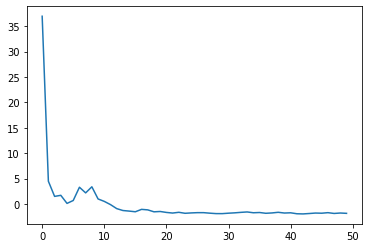

In [58]:
dataset = TwoDDataset()
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

losses = []
t = trange(50)

for epoch in t:
    epoch_loss = 0.
    for (inputs, targets) in train_dataloader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        dist = dist_constructor(outputs)
        loss = -dist.log_prob(targets)

        mean_loss = loss.mean()

        mean_loss.backward()

        epoch_loss += mean_loss
        
        optimizer.step()
        
    epoch_loss /= len(train_dataloader)
    
    t.set_description("mean_loss=%02f"%epoch_loss.item())
    losses.append(epoch_loss.item())

plt.plot(losses)

Visualize the simple trained DNN

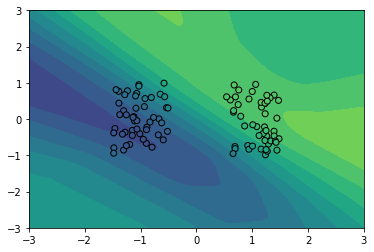

In [59]:
X1,X2 = np.meshgrid( np.linspace(-3.,3.,50), np.linspace(-3.,3.,50) )
X = np.stack([X1,X2], axis=-1)
xx_tensor = torch.from_numpy(X).view(-1,2).float()
yhat = model(xx_tensor)
yhat = yhat[:,0].detach().cpu().numpy()

plt.contourf(X1,X2,yhat.reshape(X1.shape), levels=10, vmin=-2., vmax=2.)
plt.scatter(dataset.X[:,0], dataset.X[:,1], c=dataset.Y, vmin=-2, vmax=2, edgecolors='k')

### Applying SCOD
Now, we apply SCOD to the network to add uncertainty estimation

In [60]:
unc_model = scod.SCOD(model, dist_constructor, args={
    'num_eigs': 50,
    'num_samples': 304,
    'sketch_type': 'srft',
    'prior_type': 'per_parameter',
})

Weight space dimension: 8.577e+03


### process training dataset to compute posterior uncertainty

In [80]:
unc_model.process_dataset(dataset)

computing basis
using T = 304


### use validation dataset to optimize prior variance

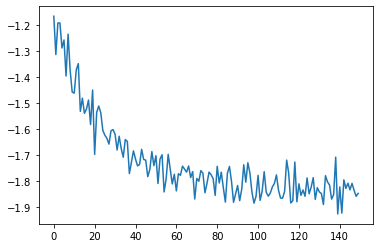

In [81]:
val_dataset = TwoDDataset(split='val')
unc_model.log_prior_scale.data *= 0
loss_curve = unc_model.optimize_prior_scale_by_nll(val_dataset, num_epochs=30)
plt.plot(loss_curve)

In [82]:
val_optim_prior = unc_model.log_prior_scale

## Using a GP to regularize SCOD

In [61]:
gp_reg_unc_model = scod.SCOD(model, dist_constructor, args={
    'num_eigs': 50,
    'num_samples': 304,
    'sketch_type': 'srft',
    'prior_type': 'per_weight',
})

Weight space dimension: 8.577e+03


First, we optimize the prior scale to match a squared exponential GP

In [62]:
def GP_kernel(inputs):
    sq_dist = torch.norm( (inputs[:,None,:] - inputs[None,:,:]), dim=-1 )**2
    length_scale = 0.2
    kernel = torch.exp(- sq_dist / length_scale)
    return kernel

uniform_dataset = UniformDataset()
gp_reg_unc_model.log_prior_scale.data *= 0
loss_curve, min_eigs = gp_reg_unc_model.optimize_prior_scale_by_GP_kernel(uniform_dataset, GP_kernel, num_epochs=30, batch_size=10)

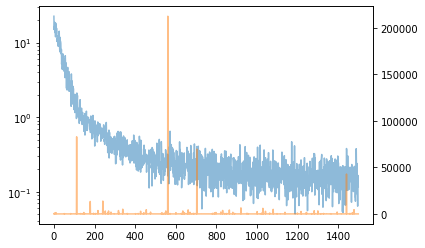

In [63]:
fig, ax = plt.subplots()
ax.semilogy(loss_curve, alpha=0.5)
ax2 = ax.twinx()
ax2.plot(1./np.array(min_eigs), color='C1', alpha=0.5)

Now, we compute the GGN in the rescaled space:

In [64]:
gp_reg_unc_model.process_dataset(dataset)

computing basis
using T = 304


## Alternative GP:
Only count distance in y direction

In [65]:
gp_reg_unc_model_2 = scod.SCOD(model, dist_constructor, args={
    'num_eigs': 50,
    'num_samples': 304,
    'sketch_type': 'srft',
    'prior_type': 'per_weight',
})

Weight space dimension: 8.577e+03


In [66]:
def GP_kernel_y_only(inputs):
    sq_dist = ( (inputs[:,None,1] - inputs[None,:,1])**2 )
    length_scale = 0.2
    kernel = torch.exp(- sq_dist / length_scale)
    return kernel

uniform_dataset = UniformDataset()
gp_reg_unc_model_2.log_prior_scale.data *= 0
loss_curve, min_eigs = gp_reg_unc_model_2.optimize_prior_scale_by_GP_kernel(uniform_dataset, GP_kernel_y_only, num_epochs=30, batch_size=10)

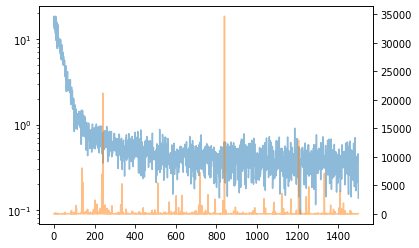

In [67]:
fig, ax = plt.subplots()
ax.semilogy(loss_curve, alpha=0.5)
ax2 = ax.twinx()
ax2.plot(1./np.array(min_eigs), color='C1', alpha=0.5)

In [68]:
gp_reg_unc_model_2.process_dataset(dataset)

computing basis
using T = 304


### compare SCOD's predictions to the original trained model

In [69]:
settings = [
    {   
        'name': 'Unit Prior',
        'model': unc_model,
        'prior_scales': 0*unc_model.log_prior_scale,
    },
    {   
        'name': 'Val Optimized Prior',
        'model': unc_model,
        'prior_scales': None,
    },
    {   
        'name': 'GP Optimized Prior',
        'model': gp_reg_unc_model,
        'prior_scales': None,
    },
    {   
        'name': 'GP Optimized Prior 2',
        'model': gp_reg_unc_model_2,
        'prior_scales': None,
    },
]

In [70]:
X1,X2 = np.meshgrid( np.linspace(-3.,3.,50), np.linspace(-3.,3.,50) )
X = np.stack([X1,X2], axis=-1)
xx_tensor = torch.from_numpy(X).view(-1,2).float()
yhat = model(xx_tensor)
yhat = yhat[:,0].detach().cpu().numpy()

In [83]:
results = []
for setting in settings:
    scod_model = setting['model']
    old_prior_scales = scod_model.log_prior_scale.data + 0.
    if setting['prior_scales'] is not None:
        scod_model.log_prior_scale.data = setting['prior_scales']
    
    dists, _ = scod_model(xx_tensor)
    prior_dists, _ = scod_model(xx_tensor, use_prior=True)

    scod_model.log_prior_scale.data = old_prior_scales
    vars = np.array( [torch.sqrt(dist.variance).sum().detach().cpu() for dist in dists] )
    prior_vars = np.array( [torch.sqrt(dist.variance).sum().detach().cpu() for dist in prior_dists] )
    result = {
        'name': setting['name'],
        'vars': vars.reshape(X1.shape),
        'prior_vars': prior_vars.reshape(X1.shape)
    }
    results.append(result)

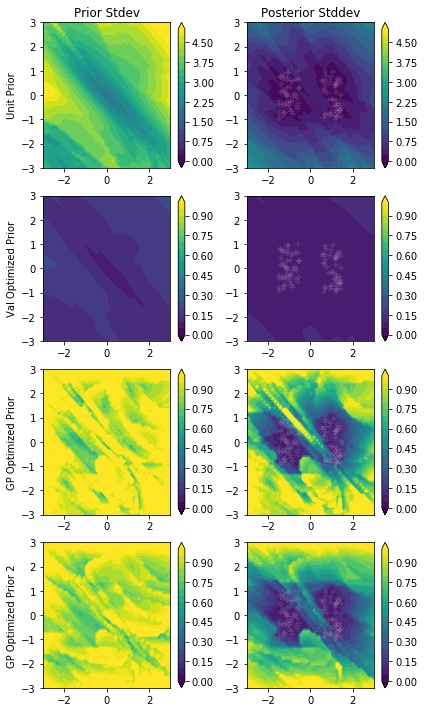

In [85]:
fig, axes = plt.subplots(len(results), 2, figsize=[6,10])
for i, result in enumerate(results):
    max_unc = max(np.round(np.quantile(result['prior_vars'], 0.9) /0.9 ), 1.)
    levels = np.linspace(0., max_unc, 21)
    m = axes[i,0].contourf(X1,X2,result['prior_vars'], vmin=0., vmax=max_unc, extend='both', levels=levels)
    plt.colorbar(m, ax=axes[i,0])
    m.set_clim([0, m.get_clim()[1]])
    m = axes[i,1].contourf(X1,X2,result['vars'], vmin=0., vmax=max_unc, extend='both', levels=levels)
    plt.colorbar(m, ax=axes[i,1])
    m.set_clim([0, m.get_clim()[1]])
    axes[i,1].scatter(dataset.X[:,0], dataset.X[:,1], marker='+', vmin=-2, vmax=2, color='white', alpha=0.1)

    axes[i,0].set_ylabel(result['name'])

axes[0,0].set_title('Prior Stdev')
axes[0,1].set_title('Posterior Stddev')

plt.tight_layout()

Text(0.5, 1.0, 'Distribution of per-weight prior variances')

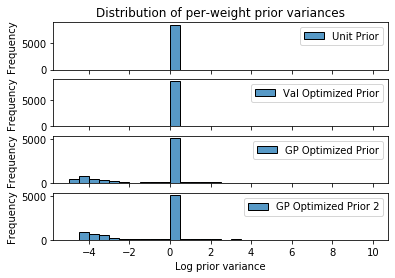

In [ ]:
fig, axes = plt.subplots(len(settings),1, sharex=True)

for ax, setting in zip(axes, settings):
    log_prior_scale = setting['model'].log_prior_scale.detach().cpu()
    if setting['prior_scales'] is not None:
        log_prior_scale = setting['prior_scales'].detach().cpu()
    sns.histplot(setting['model']._broadcast_to_n_weights(log_prior_scale), ax=ax, label=setting['name'], binrange=[-5,10], binwidth=0.5)
    ax.legend()
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Log prior variance')

axes[0].set_title('Distribution of per-weight prior variances')
